Link: https://www.vinta.com.br/blog/2018/understanding-time-series-forecasting-python/

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime

In [2]:
# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 505)

# Load Data

In [3]:
df = pd.read_csv('bitcoin_price_Training.csv')
df.shape

(1556, 7)

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


# Data Preprocessing

In [5]:
# Change "Date" column into a DateTime data type
df.Date = pd.to_datetime(df.Date)

In [6]:
# Sort "Date" column in ascending order
df = df.sort_values(by = 'Date', ascending = True)

In [7]:
# Make "Date" column the index of the DataFrame
df.set_index('Date', inplace = True)

In [8]:
# Create a time series
ts_data = df['High']

# Preliminary Analysis

To explore the dataset:
    + Are there consisten patterns?
    + Is there a significant trend?
    + Is seasonality important?
    + Is there evidence of the presence of business cycles?
    + Are there any outliers in the data that need to be explained by those with expert knowledge?
    + How strong are the relationships among the variables available for analysis?

## Visualize TS data
   Graphs allow to visualize many features of the data, including patterns, unusual observations, changes over time, and relationships between variable

### TS data plot

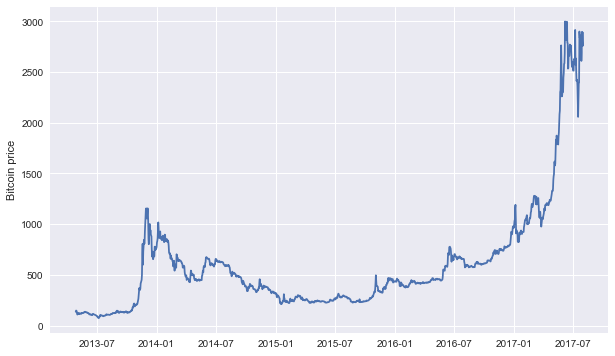

In [13]:
plt.figure(figsize=(10,6))
plt.plot(df.index,df['High'])
plt.ylabel('Bitcoin price')
plt.show()

=> Analyzing the graph, some distinguishable patterns appear:
   + The time series has an overall increasing trend
   + At some points of 2014, the price passed the 1000 mark
   + After the 2014 peak, the price wouldn't break the 1000 mark again for another 3 years
   + At some point of 2017, the price increases again

### Decomposition plot

Time series data can exhibit a huge variety of patterns and it's helpful to split a time series into several components, each representing one of the underlying categories of a pattern. Usually a time series can be segmented into four patterns: Trend, Seasonal, Cycles, Noise

Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data. These can be used to understand the structure of our time-series. The intuition behind time-series decomposition is important, as many forecasting methods build upon this concept of structured decomposition to produce forecasts

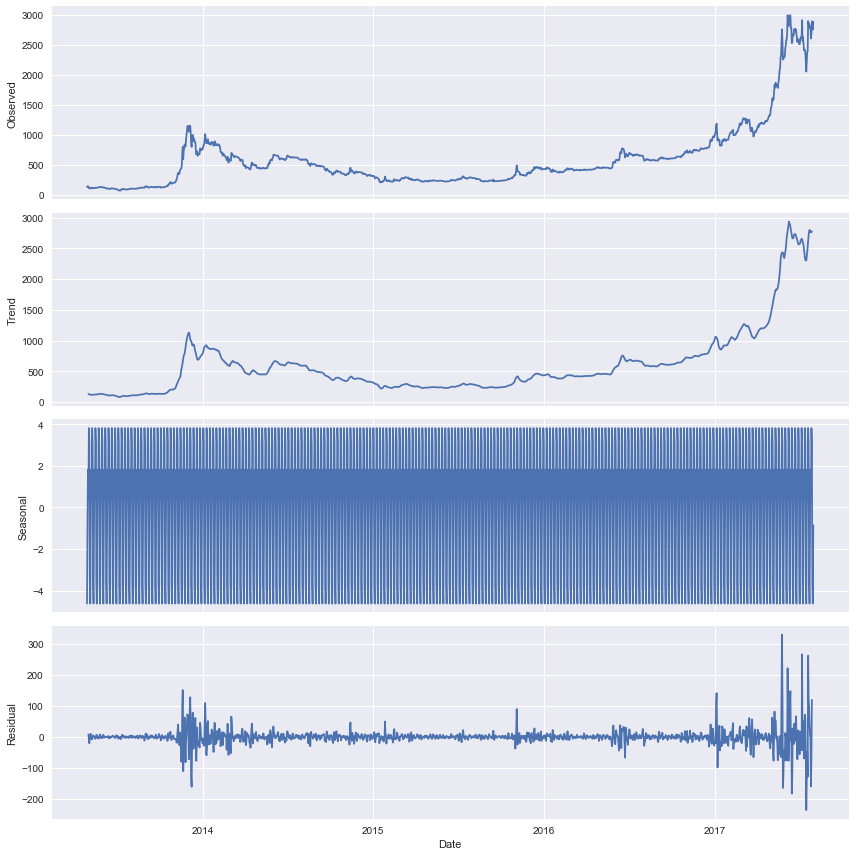

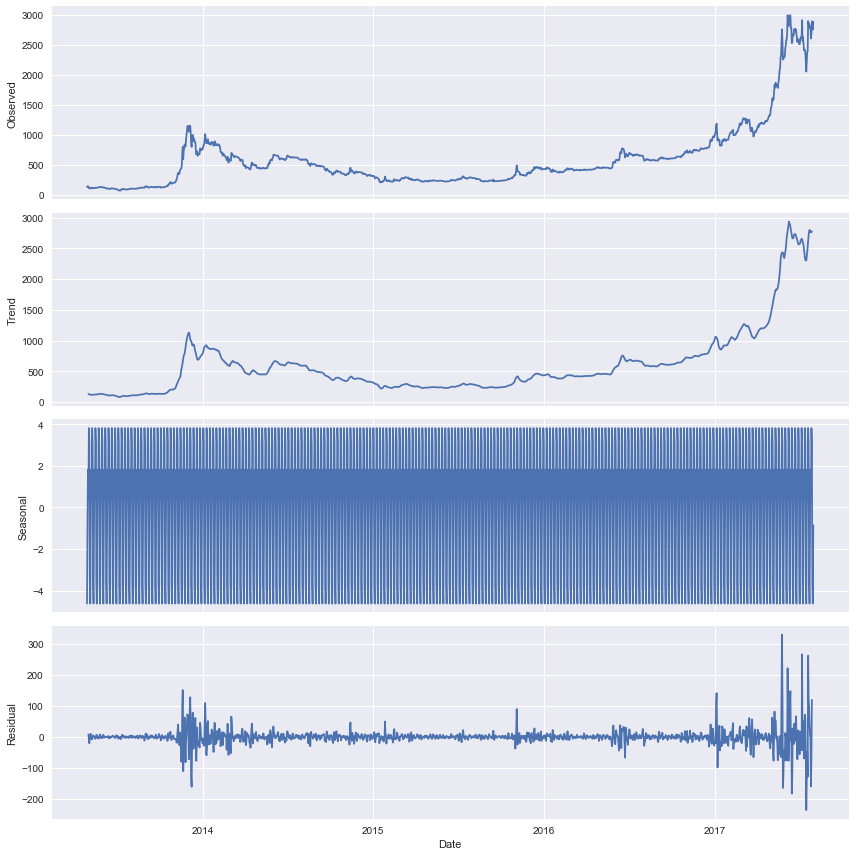

In [17]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df['High'], model='additive')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 12
decomposition.plot()

=> Interpretation:
   + The seasonal part of the graph shows strong seasonality within each day
   + On the trend part of the graph, there is no seasonality, but an obvious rising trend
   + The graph shows no evidence of any cyclic behavior
   + The residual graph shows no trend, seasonality of cyclic behavior. There are random fluctuations which do not appear to be very predictable

### Correlogram: Autocorrelation function

Purpose: Detect non-randomness in data.Identify an appropriate time series model if the data is not random

Text(0, 0.5, 'ACF')

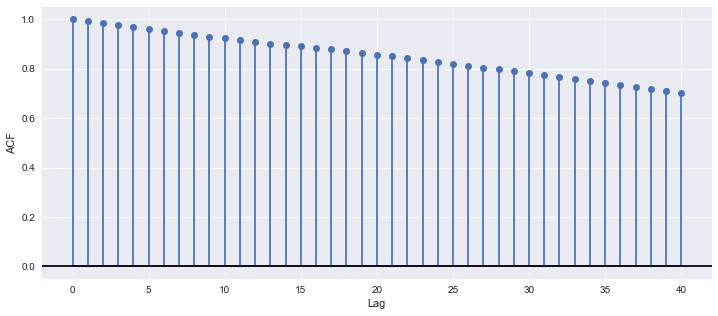

In [18]:
from statsmodels.tsa.stattools import acf
lac_acf = acf(df['High'], nlags = 40)
plt.figure(figsize = (12,5))
plt.stem(lac_acf)
plt.axhline(y=0, linestyle='-', color = 'black')
plt.xlabel('Lag')
plt.ylabel('ACF')

=> Interpretation:
   + All correlograms start at 1; this is because when t = 0, we are comparing the time series with itself
   + We can see that the time series is not random, but rather has a high degree of autocorrelation of adjacent and near-adjacent observations

### Time Series Analysis Plots

In [19]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags = None, figsize=(12,8), style = 'bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax = ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags = lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    
    return

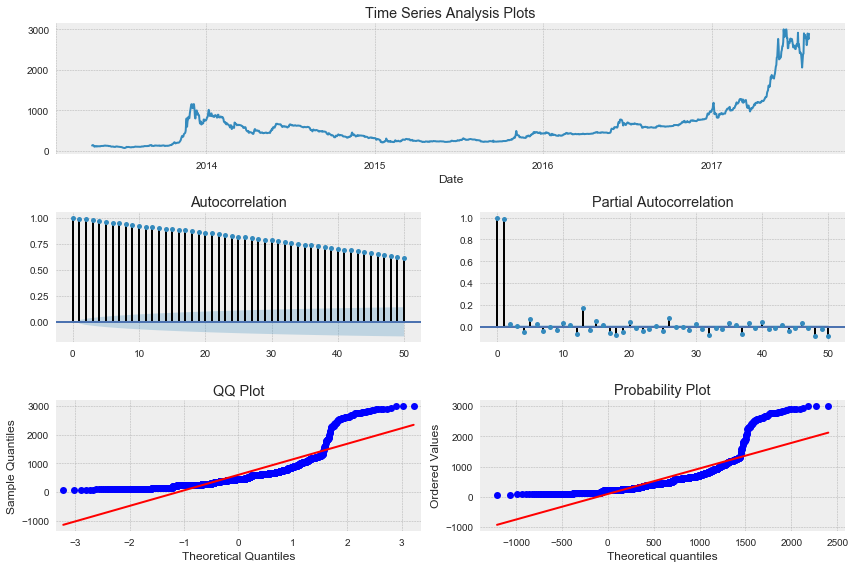

In [21]:
tsplot(df['High'], lags=50)

### Check Stationary

There are two ways to check the stationarity of a time series:
   1. Plotting Rolling Statistics
   2. Dickey-Fuller Test

In [30]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
def check_stationarity(timeseries):
    # Determing rolling statistics
    rolling_mean = timeseries.rolling(window=52, center=False).mean()
    rolling_std = timeseries.rolling(window = 52, center = False).std()
        
    # Plot rolling statistics
    plt.figure(figsize=(16,7))
    plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color ='blue', label = 'Original')
    plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)' %key] = value
    print(dfresults)

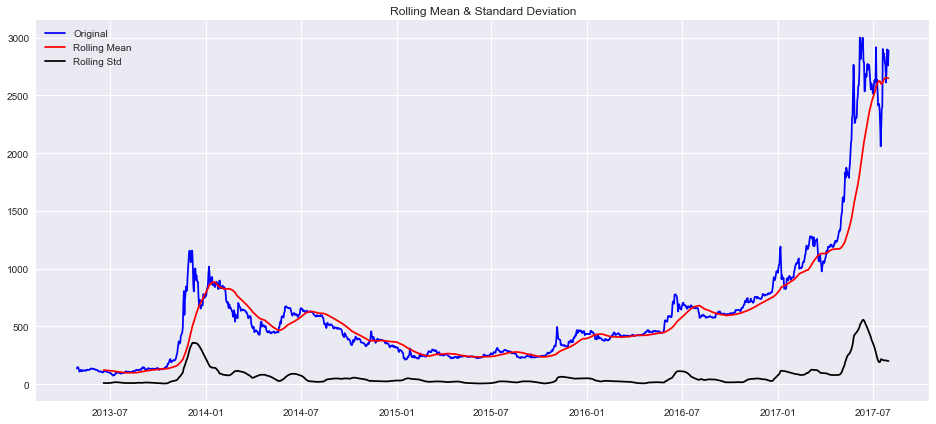

Results of Dickey-Fuller Test:
Test Statistic                    2.511750
p-value                           0.999054
#Lags Used                       24.000000
Number of Observations Used    1531.000000
Critical Value (1%)              -3.434628
Critical Value (5%)              -2.863430
Critical Value (10%)             -2.567776
dtype: float64


In [31]:
check_stationarity(ts_data)

# Stationaries the time series

### Apply a nonlinear log transformation

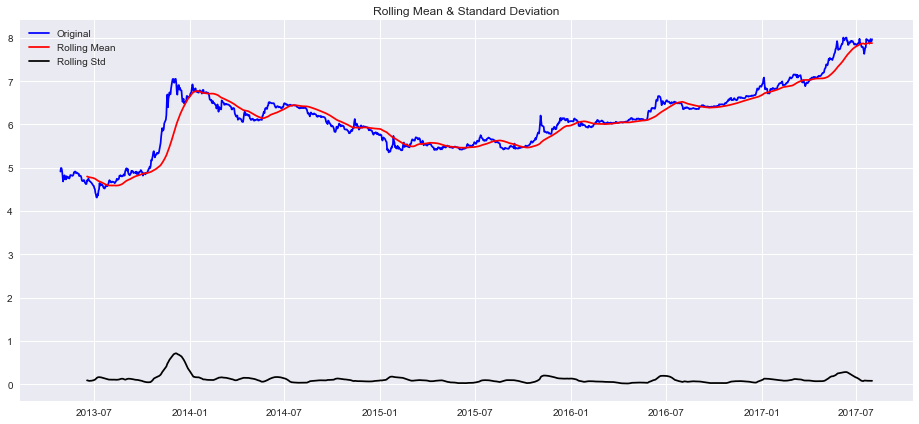

Results of Dickey-Fuller Test:
Test Statistic                   -0.685431
p-value                           0.850487
#Lags Used                        5.000000
Number of Observations Used    1550.000000
Critical Value (1%)              -3.434576
Critical Value (5%)              -2.863406
Critical Value (10%)             -2.567764
dtype: float64


In [32]:
ts_data_log = np.log(ts_data)
check_stationarity(ts_data_log)

In [36]:
np.log(np.e)

1.0

### Remove trend and seasonality with differencing

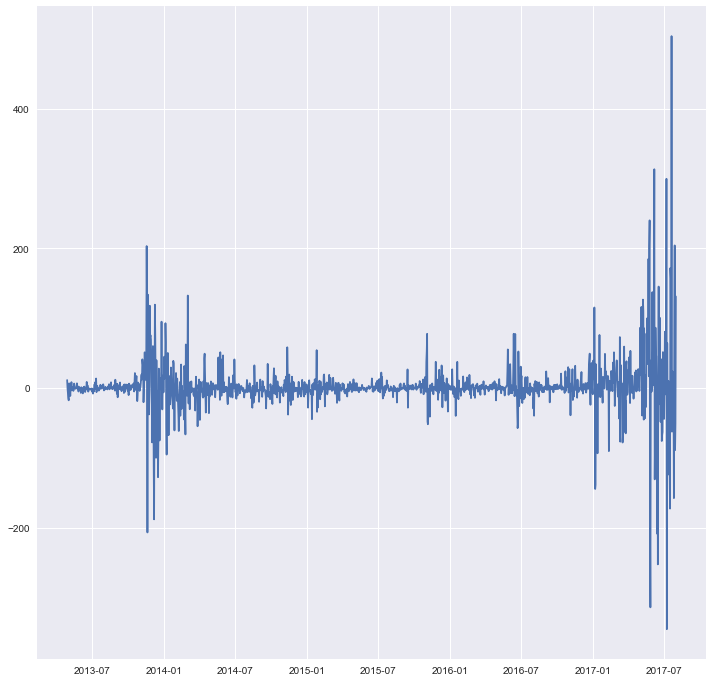

In [34]:
ts_data_diff = ts_data - ts_data.shift()
plt.plot(ts_data_diff.index.to_pydatetime(), ts_data_diff.values)

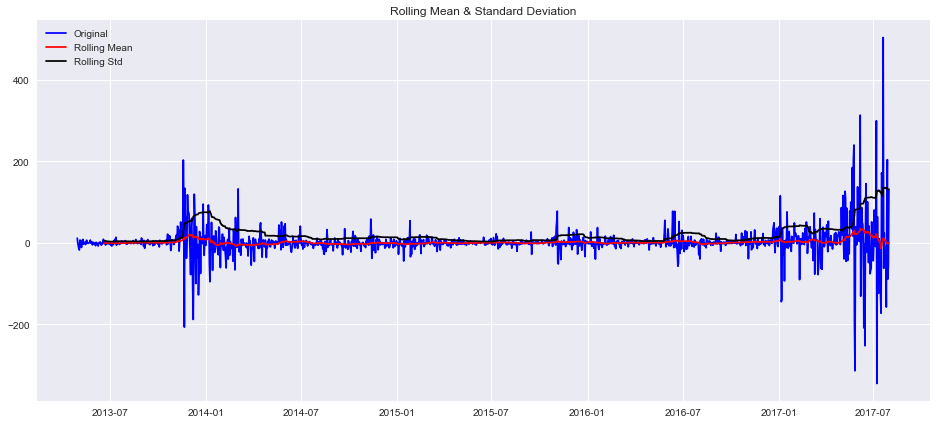

Results of Dickey-Fuller Test:
Test Statistic                -7.647488e+00
p-value                        1.826219e-11
#Lags Used                     2.300000e+01
Number of Observations Used    1.531000e+03
Critical Value (1%)           -3.434628e+00
Critical Value (5%)           -2.863430e+00
Critical Value (10%)          -2.567776e+00
dtype: float64


In [37]:
ts_data_diff.dropna(inplace=True)
check_stationarity(ts_data_diff)

# Build ARIMA model

### Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF)

In [38]:
lag_auto_corr = acf(ts_data_diff, nlags=20)
lag_par_auto_corr = pacf(ts_data_diff, nlags=20, method='ols')

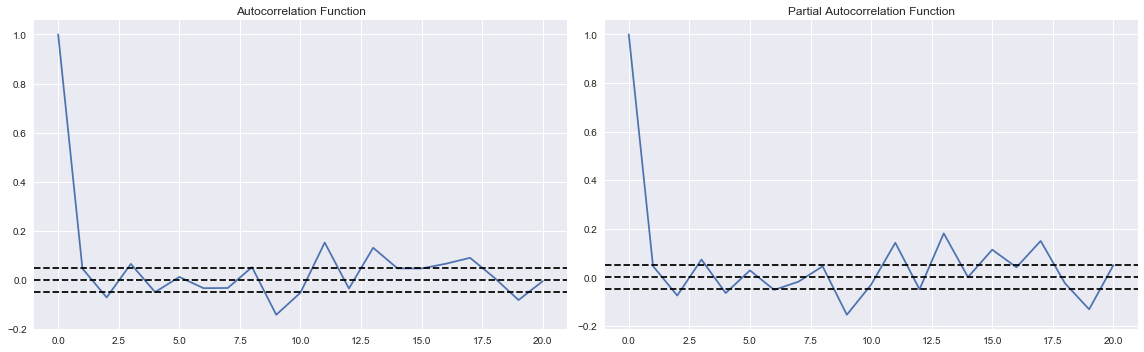

In [39]:
# Plot ACF & PACF: style 1
plt.figure(figsize=(16,5))
# ACF
plt.subplot(121)
plt.plot(lag_auto_corr)
plt.axhline(y=0, linestyle = '--', color='black')
plt.axhline(y=-1.96/np.sqrt(len(ts_data_diff)), linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(ts_data_diff)),linestyle='--', color='black')
plt.title('Autocorrelation Function')
# PACF
plt.subplot(122)
plt.plot(lag_par_auto_corr)
plt.axhline(y=0,linestyle='--', color='black')
plt.axhline(y=-1.96/np.sqrt(len(ts_data_diff)), linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(ts_data_diff)), linestyle='--', color='black')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

[]

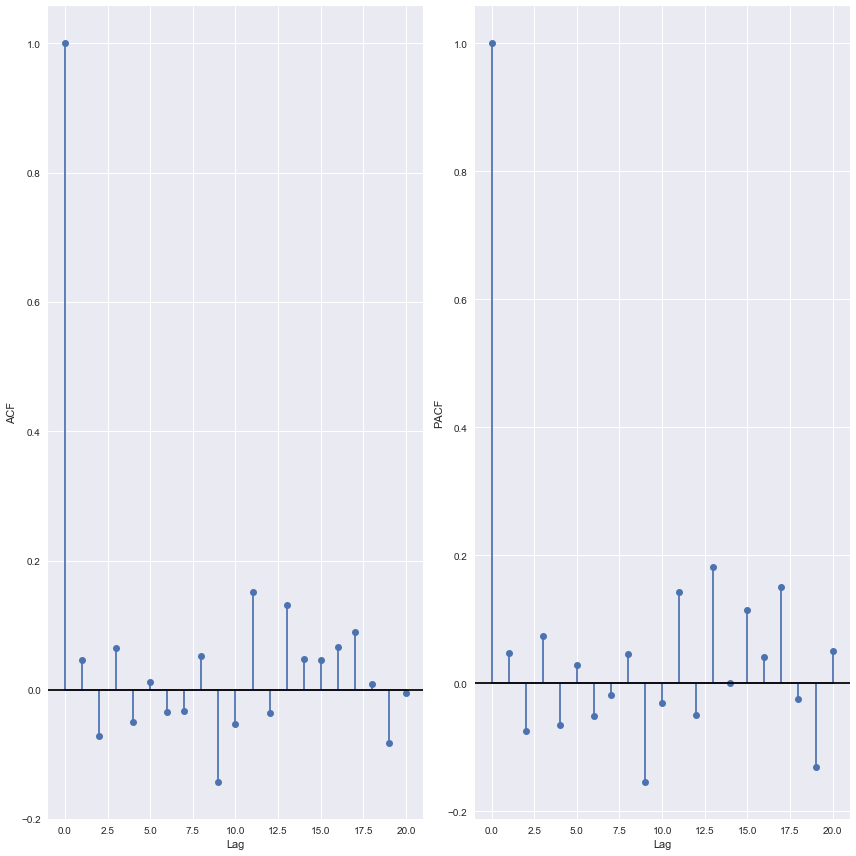

In [45]:
# Plot ACF & PACF: style 2
# ACF
plt.subplot(121)
plt.stem(lag_auto_corr)
plt.axhline(y=0, linestyle='-', color='black')
plt.xlabel('Lag')
plt.ylabel('ACF')
# PACF
plt.subplot(122)
plt.stem(lag_par_auto_corr)
plt.axhline(y=0, linestyle='-', color='black')
plt.xlabel('Lag')
plt.ylabel('PACF')

plt.tight_layout()


### Train the model

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[]

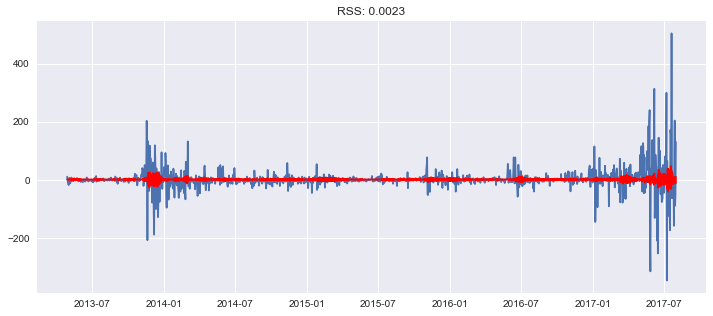

In [44]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_data, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(12,5))
plt.plot(ts_data_diff.index.to_pydatetime(), ts_data_diff.values)
plt.plot(ts_data_diff.index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum(results_ARIMA.fittedvalues - ts_data_diff) ** 2)
plt.plot()

### Print the results of the ARIMA model

In [46]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.High   No. Observations:                 1555
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7793.968
Method:                       css-mle   S.D. of innovations             36.349
Date:                Mon, 10 Jun 2019   AIC                          15599.936
Time:                        17:46:52   BIC                          15632.032
Sample:                    04-29-2013   HQIC                         15611.871
                         - 07-31-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.7670      0.911      1.940      0.053      -0.019       3.553
ar.L1.D.High    -0.1524      0.220     -0.694      0.487      -0.583       0.278
ar.L2.D.High     0.6536      0.198      3.30

### Plot residual errors

                 0
count  1555.000000
mean     -0.000031
std      36.360819
min    -351.924927
25%      -6.279964
50%      -1.843293
75%       4.098143
max     471.513938


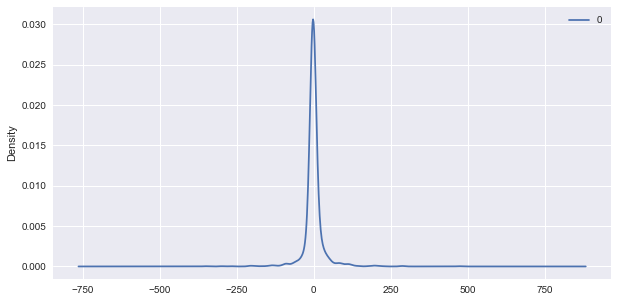

In [47]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde', figsize=(10,5))
print(residuals.describe())

### Scale predictions (taking it back to the original scale)

Text(0.5, 1.0, 'RMSE: 1132.4050')

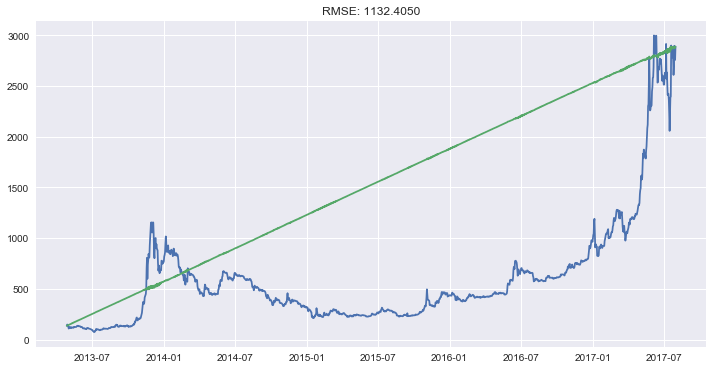

In [48]:
# Scale predictions
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(ts_data.iloc[0], index=ts_data.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)
# observe data
ts_data.head()
predictions_ARIMA_diff.head()
predictions_ARIMA_diff_cumsum.head()
predictions_ARIMA.head()
# plot original values vs predicted values
plt.figure(figsize=(12,6))
plt.plot(ts_data.index.to_pydatetime(), ts_data.values)
plt.plot(predictions_ARIMA.index.to_pydatetime(), predictions_ARIMA.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_data)**2)/len(ts_data)))

### Perform and visualize forecast

In [49]:
# split data into 2 sets: train set and test set
size = int(len(ts_data) - 30)
train, test = ts_data[0:size], ts_data[size:len(ts_data)]
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(historical, order=(2,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted value = %f, Expected value = %f' % (yhat, observed))

Printing Predicted vs Expected Values...


Predicted value = 2505.189242, Expected value = 2514.280000
Predicted value = 2519.760515, Expected value = 2595.000000
Predicted value = 2614.649071, Expected value = 2631.590000
Predicted value = 2621.152361, Expected value = 2622.650000
Predicted value = 2632.338396, Expected value = 2616.720000
Predicted value = 2611.675442, Expected value = 2916.140000
Predicted value = 2984.828043, Expected value = 2571.340000
Predicted value = 2476.140038, Expected value = 2635.490000
Predicted value = 2713.513172, Expected value = 2537.160000
Predicted value = 2512.775534, Expected value = 2413.470000
Predicted value = 2424.432194, Expected value = 2423.710000
Predicted value = 2437.438537, Expected value = 2425.220000
Predicted value = 2399.515087, Expected value = 2363.250000
Predicted value = 2394.916845, Expected value = 2231.140000
Predicted value = 2226.926894, Expected value = 2058.770000
Predicted value = 2068.244766, Expected value = 2230.4900

[]

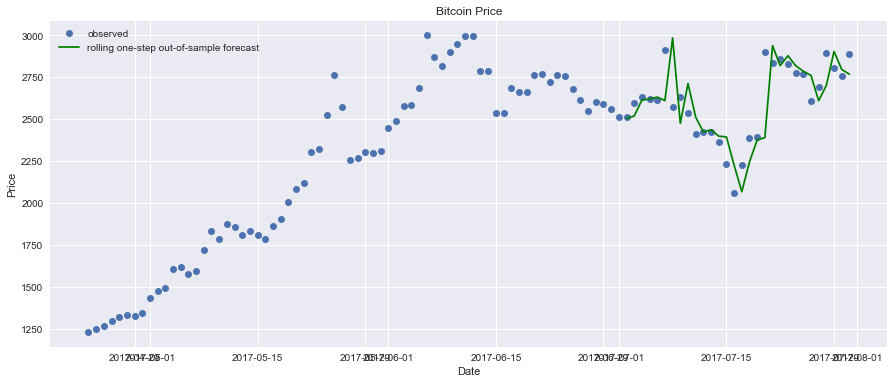

In [52]:
# calculate error
from sklearn.metrics import mean_squared_error    
error = mean_squared_error(test, predictions)

# visualize time series forecast
rcParams['figure.figsize'] = 15, 6
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots()
ax.set(title='Bitcoin Price', xlabel='Date', ylabel='Price')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()